In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
import pywt

import scipy
from scipy.fft import fft
from scipy.signal import welch

from collections import Counter

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, SpatialDropout1D, BatchNormalization, Embedding, Activation, Input, concatenate
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D, SpatialDropout2D

from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import History 

!pip install detecta
from detecta import detect_peaks

In [2]:
os.chdir('C:/Users/dkornev/Desktop/Work Folder/My Folders/Harrisburg University/ISEM 780-52-A-2021 Fall - Doctoral Research Seminar/Experiment')
os.getcwd()

'C:\\Users\\dkornev\\Desktop\\Work Folder\\My Folders\\Harrisburg University\\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\\Experiment'

In [3]:
#####################################
#####################################
# IGT function creation
def IGT(a):
    a = a.TL02.str.split(r'\t', expand=True) # dividing by columns; !!!the whole dataset is more than 200 trials (201)!!!
    a.columns = ['Time', 'Time1', 'Mark'] # rename columns
    a.drop('Time1', axis = 1, inplace = True) # drop colunm "0"

    # Sort decision time points (DTP) only and dividing by 10 Blocks
    igt1 = a[(a.Mark == '"PP 1"') | (a.Mark == '"PP 2"') | (a.Mark == '"PP 3"') | (a.Mark == '"PP 4"')]
    igt1.columns = ['DTP', 'Deck']
    igt1 = igt1.reset_index(drop = True)
    igt1['Block'] = pd.DataFrame(np.repeat(np.arange(0, 10), 20))
    igt1 = igt1.dropna(axis=0, how='any') # erasing NaN rows

    # Sort reaction time points (RTP)
    # PP9 - win
    # PP10 - loss
    igt2 = a[(a.Mark == '"PP 9"') | (a.Mark == '"PP 10"')]
    igt2.columns = ['RTP', 'Result']
    igt2 = igt2.reset_index(drop = True)

    # The whole IGT dataset
    igt = igt1.join(igt2)
    igt = igt.fillna(method='ffill')

    # Rename decks and results
    igt['RTP'] = igt['RTP'].astype(str).astype(int)
    igt['DTP'] = igt['DTP'].astype(str).astype(int)
    igt.loc[(igt.Deck == '"PP 1"'), 'Deck'] = 'A'
    igt.loc[(igt.Deck == '"PP 2"'), 'Deck'] = 'B'
    igt.loc[(igt.Deck == '"PP 3"'), 'Deck'] = 'C' 
    igt.loc[(igt.Deck == '"PP 4"'), 'Deck'] = 'D'
    igt.loc[(igt.Result == '"PP 9"'), 'Result'] = '1' 
    igt.loc[(igt.Result == '"PP 10"'), 'Result'] = '0'
    
    # Dividing by IGT blocks
    igtBlock1 = igt[0:20]
    igtBlock2 = igt[20:40]
    igtBlock3 = igt[40:60]
    igtBlock4 = igt[60:80]
    igtBlock5 = igt[80:100]
    igtBlock6 = igt[100:120]
    igtBlock7 = igt[120:140]
    igtBlock8 = igt[140:160]
    igtBlock9 = igt[160:180]
    igtBlock10 = igt[180:200]

    # IGT Score calculation

    igtBlock1A = igtBlock1[(igtBlock1.Deck == 'A')]
    igtBlock1B = igtBlock1[(igtBlock1.Deck == 'B')]
    igtBlock1C = igtBlock1[(igtBlock1.Deck == 'C')]
    igtBlock1D = igtBlock1[(igtBlock1.Deck == 'D')]

    igtBlock2A = igtBlock2[(igtBlock2.Deck == 'A')]
    igtBlock2B = igtBlock2[(igtBlock2.Deck == 'B')]
    igtBlock2C = igtBlock2[(igtBlock2.Deck == 'C')]
    igtBlock2D = igtBlock2[(igtBlock2.Deck == 'D')]

    igtBlock3A = igtBlock3[(igtBlock3.Deck == 'A')]
    igtBlock3B = igtBlock3[(igtBlock3.Deck == 'B')]
    igtBlock3C = igtBlock3[(igtBlock3.Deck == 'C')]
    igtBlock3D = igtBlock3[(igtBlock3.Deck == 'D')]

    igtBlock4A = igtBlock4[(igtBlock4.Deck == 'A')]
    igtBlock4B = igtBlock4[(igtBlock4.Deck == 'B')]
    igtBlock4C = igtBlock4[(igtBlock4.Deck == 'C')]
    igtBlock4D = igtBlock4[(igtBlock4.Deck == 'D')]

    igtBlock5A = igtBlock5[(igtBlock5.Deck == 'A')]
    igtBlock5B = igtBlock5[(igtBlock5.Deck == 'B')]
    igtBlock5C = igtBlock5[(igtBlock5.Deck == 'C')]
    igtBlock5D = igtBlock5[(igtBlock5.Deck == 'D')]
    
    igtBlock6A = igtBlock6[(igtBlock6.Deck == 'A')]
    igtBlock6B = igtBlock6[(igtBlock6.Deck == 'B')]
    igtBlock6C = igtBlock6[(igtBlock6.Deck == 'C')]
    igtBlock6D = igtBlock6[(igtBlock6.Deck == 'D')]
    
    igtBlock7A = igtBlock7[(igtBlock7.Deck == 'A')]
    igtBlock7B = igtBlock7[(igtBlock7.Deck == 'B')]
    igtBlock7C = igtBlock7[(igtBlock7.Deck == 'C')]
    igtBlock7D = igtBlock7[(igtBlock7.Deck == 'D')]

    igtBlock8A = igtBlock8[(igtBlock8.Deck == 'A')]
    igtBlock8B = igtBlock8[(igtBlock8.Deck == 'B')]
    igtBlock8C = igtBlock8[(igtBlock8.Deck == 'C')]
    igtBlock8D = igtBlock8[(igtBlock8.Deck == 'D')]

    igtBlock9A = igtBlock9[(igtBlock9.Deck == 'A')]
    igtBlock9B = igtBlock9[(igtBlock9.Deck == 'B')]
    igtBlock9C = igtBlock9[(igtBlock9.Deck == 'C')]
    igtBlock9D = igtBlock9[(igtBlock9.Deck == 'D')]

    igtBlock10A = igtBlock10[(igtBlock10.Deck == 'A')]
    igtBlock10B = igtBlock10[(igtBlock10.Deck == 'B')]
    igtBlock10C = igtBlock10[(igtBlock10.Deck == 'C')]
    igtBlock10D = igtBlock10[(igtBlock10.Deck == 'D')]
    
    # IGTscore = sum(C) + sum(D) - sum(A) - sum(B) by blocks
    igtBlock1Score = igtBlock1C.shape[0] + igtBlock1D.shape[0] - igtBlock1A.shape[0] - igtBlock1B.shape[0]
    igtBlock2Score = igtBlock2C.shape[0] + igtBlock2D.shape[0] - igtBlock2A.shape[0] - igtBlock2B.shape[0]
    igtBlock3Score = igtBlock3C.shape[0] + igtBlock3D.shape[0] - igtBlock3A.shape[0] - igtBlock3B.shape[0]
    igtBlock4Score = igtBlock4C.shape[0] + igtBlock4D.shape[0] - igtBlock4A.shape[0] - igtBlock4B.shape[0]
    igtBlock5Score = igtBlock5C.shape[0] + igtBlock5D.shape[0] - igtBlock5A.shape[0] - igtBlock5B.shape[0]
    igtBlock6Score = igtBlock6C.shape[0] + igtBlock6D.shape[0] - igtBlock6A.shape[0] - igtBlock6B.shape[0]
    igtBlock7Score = igtBlock7C.shape[0] + igtBlock7D.shape[0] - igtBlock7A.shape[0] - igtBlock7B.shape[0]
    igtBlock8Score = igtBlock8C.shape[0] + igtBlock8D.shape[0] - igtBlock8A.shape[0] - igtBlock8B.shape[0]
    igtBlock9Score = igtBlock9C.shape[0] + igtBlock9D.shape[0] - igtBlock9A.shape[0] - igtBlock9B.shape[0]
    igtBlock10Score = igtBlock10C.shape[0] + igtBlock10D.shape[0] - igtBlock10A.shape[0] - igtBlock10B.shape[0]

    # Collect IGTscore in one row
    IGTScore = [igtBlock1Score, igtBlock2Score, igtBlock3Score, igtBlock4Score, igtBlock5Score, igtBlock6Score, igtBlock7Score, igtBlock8Score, igtBlock9Score, igtBlock10Score]
    IGTScore = pd.DataFrame(IGTScore)
    
    return IGTScore

In [4]:
#####################################
#####################################
# Trigger-Events function creation
def EVENTS(a):
    a = a.TL02.str.split(r'\t', expand=True) # dividing by columns; !!!the whole dataset is more than 200 trials (201)!!!
    a.columns = ['Time', 'Time1', 'Mark'] # rename columns
    a.drop('Time1', axis = 1, inplace = True) # drop colunm "0"

    # Sort decision time points (DTP) only and dividing by 10 Blocks
    igt1 = a[(a.Mark == '"PP 1"') | (a.Mark == '"PP 2"') | (a.Mark == '"PP 3"') | (a.Mark == '"PP 4"')]
    igt1.columns = ['DTP', 'Deck']
    igt1 = igt1.reset_index(drop = True)
    igt1['Block'] = pd.DataFrame(np.repeat(np.arange(0, 10), 20))
    
    # Sort reaction time points (RTP)
    # PP9 - win
    # PP10 - loss
    igt2 = a[(a.Mark == '"PP 9"') | (a.Mark == '"PP 10"')]
    igt2.columns = ['RTP', 'Result']
    igt2 = igt2.reset_index(drop = True)

    # The whole IGT dataset
    igt = igt1.join(igt2)
    igt = igt.dropna(axis=0, how='any') # erasing NaN rows
    igt = igt.drop_duplicates(keep='first', subset='RTP') # duplicates in rows deliting

    # Rename decks and results
    igt['RTP'] = igt['RTP'].astype(str).astype(int)
    igt['DTP'] = igt['DTP'].astype(str).astype(int)
    igt.loc[(igt.Deck == '"PP 1"'), 'Deck'] = 'A'
    igt.loc[(igt.Deck == '"PP 2"'), 'Deck'] = 'B'
    igt.loc[(igt.Deck == '"PP 3"'), 'Deck'] = 'C' 
    igt.loc[(igt.Deck == '"PP 4"'), 'Deck'] = 'D'
    igt.loc[(igt.Result == '"PP 9"'), 'Result'] = '1' 
    igt.loc[(igt.Result == '"PP 10"'), 'Result'] = '0'
    
    # Events (triggers) list creation
    igt['Tmax'] = igt['RTP'] + 800 # RTP is 0 point of trigger event, Tmax is the END point of the trigger event
    igt['Tmin'] = igt['RTP'] - 200 # RTP is 0 point of trigger event, Tmin is the START point of the trigger event
    events = igt[['Deck', 'Tmin', 'Tmax']]
    events = events.melt(id_vars=['Deck'], value_vars=['Tmin', 'Tmax'])
    events.drop('Deck', axis = 1, inplace = True)
    events.columns = ['point', 'time']
    events = events.sort_values(by=['time'])
    
    Tmin = events[(events.point == 'Tmin')]
    Tmax = events[(events.point == 'Tmax')]
    Tmax = Tmax.reset_index(drop = True)
    Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))
    Tmax['index'] = pd.DataFrame(np.arange(2001, 3001))
    events = pd.concat([Tmin, Tmax])
    events = events.reset_index(drop = True)
    events = events.sort_values(by=['time'])   
    # For following synchronization with EEG dataset EVENTS data should be adjusted by adding an appropriate columns
    
    # Set of triggers events (time window intervals) creation: 200 card selections by 1001 time points, total 200200 rows     
    intervals = pd.concat([pd.DataFrame([i], columns=['point']) for i in range(1001)]*200, ignore_index=True)
    intervals.loc[intervals.point == 0, 'point'] = '01Tmin'
    intervals.loc[intervals.point == 1000, 'point'] = '02Tmax'
    intervals['int'] = pd.DataFrame(np.arange(0, 200200)) 
    
    # Rename Tmin and Tmax points for following sorting
    intervals['point'] = intervals['point'].astype(str)
    
    # now we have the first 200 rows of Tmin (01Tmin) and the second 200 rows of Tmax (02Tmax) 
    # for following numbering simplification
    intervals = intervals.sort_values(by=['point', 'int'])
    intervals = intervals.reset_index(drop = True)
    
    # Adding new column "index" for numbering Tmin and Tmax
    A = [np.arange(1001, 1201)]
    B = [np.arange(2001, 2201)]
    AA = pd.DataFrame(A).T
    BB = pd.DataFrame(B).T
    C = pd.concat([AA, BB])
    C = C.reset_index(drop = True)
    intervals = intervals.join(C)
    intervals.columns = ['point', 'int', 'index']
    intervals = intervals.fillna(0)
    # Now we have individual indexes for each Tmin and Tmax
    
    # Sort back to 1 - 200200 by "int" column
    intervals = intervals.sort_values(by=['int'])
    intervals['index'] = intervals['index'].astype(int)
    
    # Rename points back
    intervals.loc[(intervals.point == '01Tmin'), 'point'] = 'Tmin' 
    intervals.loc[(intervals.point == '02Tmax'), 'point'] = 'Tmax'
    
     # Creation trigger events dataset
    
    events_triggers = intervals.merge(events, how = 'left', on = 'index') # merge EVENTS and INTERVALS
    
    events_triggers = events_triggers.reset_index(drop = True)
    events_triggers = events_triggers[['point_x', 'time']] # taking just two columns
    events_triggers.columns = ['intervals', 'time'] # renaming columns to "INTARVALS" and "TIME"

    events_triggers['time3'] = events_triggers['time']
    events_triggers['time3'].fillna(method='bfill', inplace=True) # filling NaN as the lower  number

    events_triggers = events_triggers.dropna(subset=['time3'])# drop NaN by the column

    events_triggers['time4'] = events_triggers['time']

    events_triggers = events_triggers.fillna(method='ffill') # filling NaN as the upper number

    events_triggers['intervals2'] = events_triggers['intervals']
    events_triggers.loc[(events_triggers.intervals2 == 'Tmin'), 'intervals2'] = '0' 
    events_triggers.loc[(events_triggers.intervals2 == 'Tmax'), 'intervals2'] = '0' 
    events_triggers['intervals2'] = events_triggers['intervals2'].astype(int)

    events_triggers['time5'] = events_triggers['time4'] + events_triggers['intervals2']
    events_triggers = events_triggers[['intervals', 'time5']]
    events_triggers.columns = ['intervals', 'time']
 
    return events_triggers

In [5]:
#####################################
#####################################
# EEG filtering function creation
def EEG(a, b):                   
    # EEG dataset creation with MEAN values by all columns. Filtering: low-pass 1Hz, High-pass 50Hz
    raw_df = a.to_data_frame()
    
    sfreq = a.info['sfreq'] # frequency setting: 1000Hz
    a.load_data()

    # Filtering: low-pass 1Hz, High-pass 43Hz
    raw_f = a.notch_filter(50)  # notch filter 50 Hz
    raw_f = a.filter(1., 43., fir_design='firwin', skip_by_annotation='edge') # FIR filter
    raw_df_f = raw_f.to_data_frame()
    raw_df_f.drop('time', axis = 1, inplace = True)
                         
    mask = ((raw_df <= 50) & (raw_df >= -50)) # removing data below -50uV and above 50uV
    raw_df_f = raw_df_f[mask]
    raw_df_f = raw_df_f.fillna(method='ffill')
    raw_df_f = raw_df_f.fillna(method='bfill')
                                            
    # Signal averaging by channels
    raw_df_f['level'] = raw_df_f.mean(axis=1)
    raw_df_f_mean = raw_df_f['level']
    raw_df_f_mean = raw_df_f_mean.to_frame()
    raw_df_f_mean['time'] = raw_df_f_mean.index

    # The whole dataset creation connecting trigger events with eeg levels by time points
    S = raw_df_f_mean.join(b.set_index('time'), on='time')
    S = S.dropna(axis=0, how='any') # erasing NaN rows
    S = S.reset_index(drop = True)
    
    # preparing dataset for following PIVOT function application
    # adding 'EPOCHS' column that reflects 200 epochs (each for each card choice) with 1001 time points
    S['epochs'] = pd.DataFrame(np.repeat(np.arange(0, 200), 1001))
    S.loc[(S.intervals == 'Tmin'), 'intervals'] = '0' 
    S.loc[(S.intervals == 'Tmax'), 'intervals'] = '1000' 
    S['intervals'] = S['intervals'].astype(int)

    # Dataset transformation, matching (Tmin, -199, -198, ..., -1, RTP(0), 1, 2,3, ....., 788, 789, Tmax) points
    S = S.pivot(index='epochs', columns='intervals', values='level')
    S = S.reset_index(drop = True)
    S_T = S.T
    S_T = S_T.reset_index(drop = True)
    S_T_T = S_T.T
    S_T_T = S_T_T.reset_index(drop = True)
    S_T_T_T = S_T_T.T
    
    return S_T_T_T

In [6]:
#####################################
#####################################
# Features extraction

def get_fft_values(signal, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(signal)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values
      
def get_psd_values(signal, T, N, f_s):
    f_values, psd_values = welch(signal, fs=f_s)
    return f_values, psd_values

def acf(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]

def get_acf_values(signal, T, N, f_s):
    acf_values = acf(signal)
    x_values = np.array([T * jj for jj in range(0, N)])
    return x_values, acf_values
    
def get_first_n_peaks(x, y, n_peaks): 
    x_, y_ = list(x), list(y)
    if len(x_) >= n_peaks:
        return x_[:n_peaks], y_[:n_peaks]
    else:
        missing_n_peaks = n_peaks-len(x_)
        return x_ + [0]*missing_n_peaks, y_ + [0]*missing_n_peaks 
    
def get_features_peaks(x_values, y_values, mph, n_peaks):
    indices_peaks = detect_peaks(y_values, mph=mph)
    peaks_x, peaks_y = get_first_n_peaks(x_values[indices_peaks], y_values[indices_peaks], n_peaks)
    return peaks_x + peaks_y

def extract_features_signal(signal, percentile, denominator, n_peaks):
    t_n = 1
    N = len(signal)
    T = t_n / N
    f_s = 1/T 
    
    cwt_waveletname = 'morl' 
    dwt_waveletname = 'db4' 
    denominator = 10 
    percentile = 5 
    n_peaks = 3
        
    features = []
    signal_min = np.nanpercentile(signal, percentile)
    signal_max = np.nanpercentile(signal, 100-percentile)
    mph = signal_min + (signal_max - signal_min)/denominator

    features += get_features_peaks(*get_fft_values(signal, T, N, f_s), mph, n_peaks)
    features += get_features_peaks(*get_psd_values(signal, T, N, f_s), mph, n_peaks)
    features += get_features_peaks(*get_acf_values(signal, T, N, f_s), mph, n_peaks)
    return features

def calculate_entropy(signal):
    counter_values = Counter(signal).most_common()
    probabilities = [elem[1]/len(signal) for elem in counter_values]
    entropy = scipy.stats.entropy(probabilities)
    return entropy

def calculate_statistics(signal):
    n5 = np.nanpercentile(signal, 5)
    n25 = np.nanpercentile(signal, 25)
    n75 = np.nanpercentile(signal, 75)
    n95 = np.nanpercentile(signal, 95)
    min_ = np.nanmin(signal)
    max_ = np.nanmax(signal)
    median = np.nanpercentile(signal, 50)
    mean = np.nanmean(signal)
    std = np.nanstd(signal)
    var = np.nanvar(signal)
    rms = np.nanmean(np.sqrt(signal**2))
    return [n5, n25, n75, n95, min_, max_, median, mean, std, var, rms]

def calculate_crossings(signal):
    zero_crossing_indices = np.nonzero(np.diff(np.array(signal) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(signal) > np.nanmean(signal)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

def get_features_dwt(signal):
    entropy = calculate_entropy(signal)
    statistics = calculate_statistics(signal)
    crossings = calculate_crossings(signal)
    return [entropy] + statistics + crossings 

def get_eeg_features(signal, waveletname):
    list_features = []
    list_coeff = pywt.wavedec(signal, waveletname)
    features = []
    for coeff in list_coeff:
         features += get_features_dwt(coeff)
    list_features += features
    return list_features

In [7]:
#####################################
#####################################
# Dataset loading

def get_dataset(file_igt, file_eeg):
    igt = pd.read_csv(file_igt)          # reading IGT data
    eeg = mne.io.read_raw_edf(file_eeg)  # reading EEG data
    IGTScore = IGT(igt)                  # IGT score file creation
    events = EVENTS(igt)                 # trigger-events file creation
    EEGdata = EEG(eeg, events)           # EEG and EVENTS synchronization
    
    return EEGdata

Creating RawArray with float64 data, n_channels=64, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


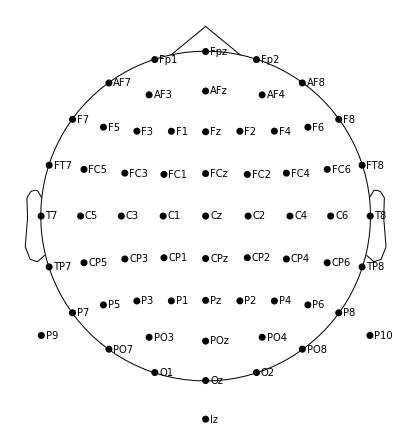

Creating RawArray with float64 data, n_channels=64, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


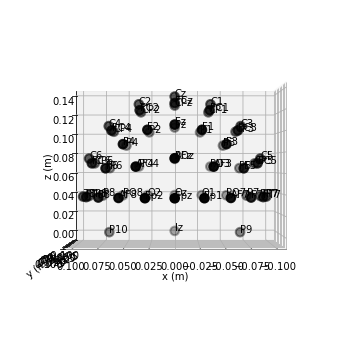

In [8]:
biosemi_montage = mne.channels.make_standard_montage('biosemi64')
biosemi_montage.plot(sphere=(0, 0, 0.035, 0.094))

fig = biosemi_montage.plot(kind='3d', scale_factor=2, show=True)
fig.gca().view_init(azim=70, elev=10)  # set view angle

In [9]:
def get_signal_features(data_dir = './', cwt_waveletname = 'morl', dwt_waveletname = 'db4', 
                     denominator = 10, percentile = 5, n_peaks = 3):
    files_list = os.listdir(data_dir)
    files_igt =   [i for i in files_list if i.split('.')[-1] == 'mrk']
    files_eeg =   [i for i in files_list if i.split('.')[-1] == 'edf']
    files_index = [i for i in files_list if 'Index' in i]
    y_index = pd.read_csv(files_index[0], header = None)

    peaks_features_ERN =  []
    peaks_features_P200 = []
    peaks_features_FRN =  []
    peaks_features_P300 = []
    peaks_features_N500 = []

    dwt_features_ERN =  []
    dwt_features_P200 = []
    dwt_features_FRN =  []
    dwt_features_P300 = []
    dwt_features_N500 = []

    cwt_features_ERN =  []
    cwt_features_P200 = []
    cwt_features_FRN =  []
    cwt_features_P300 = []
    cwt_features_N500 = []

    y = []
    
    for file_eeg in files_eeg:
        df = get_dataset(files_igt[files_igt.index(file_eeg+'.mrk')], file_eeg)
        print('Files Loading: ', files_igt[files_igt.index(file_eeg+'.mrk')], file_eeg)
        print('Events number in record: ', len(df.columns))
        print('Columns Name: ', df.columns)
        
        for i in range(0, len(df.columns)): # Event range
            # ERP intervals:
            signal_ERN  = df[i].values[280:381]
            signal_P200 = df[i].values[380:481]
            signal_FRN  = df[i].values[480:561]
            signal_P300 = df[i].values[560:781]
            signal_N500 = df[i].values[780:801]

            # Extracting features as peaks from FFT, PSD, and ACF
            peaks_features_ERN.append (extract_features_signal(signal_ERN,  percentile, denominator, n_peaks))
            peaks_features_P200.append(extract_features_signal(signal_P200, percentile, denominator, n_peaks))
            peaks_features_FRN.append (extract_features_signal(signal_FRN,  percentile, denominator, n_peaks))
            peaks_features_P300.append(extract_features_signal(signal_P300, percentile, denominator, n_peaks))
            peaks_features_N500.append(extract_features_signal(signal_N500, percentile, denominator, n_peaks))

            # Extracting features as the result of application DWT to the signal sub-bands
            dwt_features_ERN.append (get_eeg_features(signal_ERN,  dwt_waveletname))
            dwt_features_P200.append(get_eeg_features(signal_P200, dwt_waveletname))
            dwt_features_FRN.append (get_eeg_features(signal_FRN,  dwt_waveletname))
            dwt_features_P300.append(get_eeg_features(signal_P300, dwt_waveletname))
            dwt_features_N500.append(get_eeg_features(signal_N500, dwt_waveletname))

            # Extracting features as the result of application CWT to the signal
            scales = np.arange(0.1, 128)
            cwt_features_ERN.append (pywt.cwt(signal_ERN,  scales, cwt_waveletname, 1)[0])
            cwt_features_P200.append(pywt.cwt(signal_P200, scales, cwt_waveletname, 1)[0])
            cwt_features_FRN.append (pywt.cwt(signal_FRN,  scales, cwt_waveletname, 1)[0])
            cwt_features_P300.append(pywt.cwt(signal_P300, scales, cwt_waveletname, 1)[0])
            cwt_features_N500.append(pywt.cwt(signal_N500, scales, cwt_waveletname, 1)[0])

            # Label adding to each event
            y.append(int(y_index[0][int(file_eeg.split('.')[0][1:])]))

    return peaks_features_ERN, peaks_features_P200, peaks_features_FRN, peaks_features_P300, peaks_features_N500, \
             dwt_features_ERN,   dwt_features_P200,   dwt_features_FRN,   dwt_features_P300,   dwt_features_N500, \
             cwt_features_ERN,   cwt_features_P200,   cwt_features_FRN,   cwt_features_P300,   cwt_features_N500, \
             y

In [10]:
peaks_features_ERN,  peaks_features_P200, peaks_features_FRN, peaks_features_P300, peaks_features_N500, \
  dwt_features_ERN,    dwt_features_P200,   dwt_features_FRN,   dwt_features_P300,   dwt_features_N500, \
  cwt_features_ERN,    cwt_features_P200,   cwt_features_FRN,   cwt_features_P300,   cwt_features_N500, \
  y = get_signal_features(data_dir = './', 
                          cwt_waveletname = 'morl', 
                          dwt_waveletname = 'db4', 
                          denominator = 10, 
                          percentile = 5, 
                          n_peaks = 3)

Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment\S01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-4-000d69b9f050>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Reading 0 ... 1843999  =      0.000 ...  1843.999 secs...
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 43 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Up

C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 221, using nperseg = 221
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 21, using nperseg = 21
  warnings.warn('nperseg = {0:d} is greater than input length '


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment\S02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-4-000d69b9f050>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Reading 0 ... 2357999  =      0.000 ...  2357.999 secs...
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 43 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Up

C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 221, using nperseg = 221
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 21, using nperseg = 21
  warnings.warn('nperseg = {0:d} is greater than input length '


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment\S03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-4-000d69b9f050>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Reading 0 ... 1855999  =      0.000 ...  1855.999 secs...
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 43 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Up

C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 221, using nperseg = 221
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 21, using nperseg = 21
  warnings.warn('nperseg = {0:d} is greater than input length '


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment\S04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-4-000d69b9f050>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Reading 0 ... 1829999  =      0.000 ...  1829.999 secs...
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 43 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Up

C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 221, using nperseg = 221
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 21, using nperseg = 21
  warnings.warn('nperseg = {0:d} is greater than input length '


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment\S05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-4-000d69b9f050>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Reading 0 ... 1981999  =      0.000 ...  1981.999 secs...
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 43 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Up

C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 221, using nperseg = 221
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 21, using nperseg = 21
  warnings.warn('nperseg = {0:d} is greater than input length '


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment\S06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-4-000d69b9f050>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Reading 0 ... 2379999  =      0.000 ...  2379.999 secs...
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 43 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Up

C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 221, using nperseg = 221
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 21, using nperseg = 21
  warnings.warn('nperseg = {0:d} is greater than input length '


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment\S07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-4-000d69b9f050>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Reading 0 ... 1994999  =      0.000 ...  1994.999 secs...
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 43 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Up

C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 221, using nperseg = 221
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 21, using nperseg = 21
  warnings.warn('nperseg = {0:d} is greater than input length '


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment\S08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-4-000d69b9f050>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Reading 0 ... 2145999  =      0.000 ...  2145.999 secs...
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 43 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Up

C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 221, using nperseg = 221
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 21, using nperseg = 21
  warnings.warn('nperseg = {0:d} is greater than input length '


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment\S09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-4-000d69b9f050>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Reading 0 ... 1850999  =      0.000 ...  1850.999 secs...
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 43 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Up

C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 221, using nperseg = 221
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 21, using nperseg = 21
  warnings.warn('nperseg = {0:d} is greater than input length '


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment\S10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-4-000d69b9f050>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Reading 0 ... 1924999  =      0.000 ...  1924.999 secs...
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 43 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Up

C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 221, using nperseg = 221
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 21, using nperseg = 21
  warnings.warn('nperseg = {0:d} is greater than input length '


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment\S11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-4-000d69b9f050>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Reading 0 ... 1715999  =      0.000 ...  1715.999 secs...
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 43 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Up

C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 221, using nperseg = 221
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 21, using nperseg = 21
  warnings.warn('nperseg = {0:d} is greater than input length '


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment\S12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-4-000d69b9f050>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Reading 0 ... 2035999  =      0.000 ...  2035.999 secs...
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 43 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Up

C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 221, using nperseg = 221
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 21, using nperseg = 21
  warnings.warn('nperseg = {0:d} is greater than input length '


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment\S13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-4-000d69b9f050>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Reading 0 ... 1924999  =      0.000 ...  1924.999 secs...
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 43 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Up

C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 221, using nperseg = 221
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 21, using nperseg = 21
  warnings.warn('nperseg = {0:d} is greater than input length '


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment\S14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-4-000d69b9f050>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Reading 0 ... 1928999  =      0.000 ...  1928.999 secs...
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 43 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Up

C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 221, using nperseg = 221
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 21, using nperseg = 21
  warnings.warn('nperseg = {0:d} is greater than input length '


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment\S15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-4-000d69b9f050>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Reading 0 ... 2104999  =      0.000 ...  2104.999 secs...
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 43 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Up

C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 221, using nperseg = 221
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 21, using nperseg = 21
  warnings.warn('nperseg = {0:d} is greater than input length '


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment\S16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-4-000d69b9f050>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Reading 0 ... 2002999  =      0.000 ...  2002.999 secs...
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 43 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Up

C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 221, using nperseg = 221
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 21, using nperseg = 21
  warnings.warn('nperseg = {0:d} is greater than input length '


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment\S17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-4-000d69b9f050>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Reading 0 ... 2215999  =      0.000 ...  2215.999 secs...
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 43 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Up

C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 221, using nperseg = 221
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 21, using nperseg = 21
  warnings.warn('nperseg = {0:d} is greater than input length '


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment\S18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-4-000d69b9f050>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Reading 0 ... 2109999  =      0.000 ...  2109.999 secs...
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 43 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Up

C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 221, using nperseg = 221
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 21, using nperseg = 21
  warnings.warn('nperseg = {0:d} is greater than input length '


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment\S19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-4-000d69b9f050>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Reading 0 ... 2095999  =      0.000 ...  2095.999 secs...
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 43 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Up

C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 221, using nperseg = 221
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 21, using nperseg = 21
  warnings.warn('nperseg = {0:d} is greater than input length '


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment\S20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-4-000d69b9f050>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Reading 0 ... 2218999  =      0.000 ...  2218.999 secs...
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 43 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Up

C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 221, using nperseg = 221
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 21, using nperseg = 21
  warnings.warn('nperseg = {0:d} is greater than input length '


In [11]:
np.array(dwt_features_ERN).shape, np.array(dwt_features_P200).shape, np.array(dwt_features_FRN).shape, np.array(dwt_features_P300).shape, np.array(dwt_features_N500).shape

((3912, 56), (3912, 56), (3912, 56), (3912, 70), (3912, 28))

In [12]:
np.array(cwt_features_ERN).shape, np.array(cwt_features_P200).shape, np.array(cwt_features_FRN).shape, np.array(cwt_features_P300).shape, np.array(cwt_features_N500).shape

((3912, 128, 101),
 (3912, 128, 101),
 (3912, 128, 81),
 (3912, 128, 221),
 (3912, 128, 21))

In [13]:
np.array(peaks_features_ERN).shape, np.array(peaks_features_P200).shape, np.array(peaks_features_FRN).shape, np.array(peaks_features_P300).shape, np.array(peaks_features_N500).shape

((3912, 18), (3912, 18), (3912, 18), (3912, 18), (3912, 18))

In [15]:
np.array(y).shape, np.unique(y)

((3912,), array([0, 1]))

# Normalization

In [230]:
peaks_features_ERN_norm = preprocessing.normalize(peaks_features_ERN)
cwt_features_ERN_norm   = np.array(cwt_features_ERN) / np.sqrt(np.sum((np.array(cwt_features_ERN))**2))
dwt_features_ERN_norm   = preprocessing.normalize(dwt_features_ERN)

peaks_features_P200_norm = preprocessing.normalize(peaks_features_P200)
cwt_features_P200_norm   = np.array(cwt_features_P200) / np.sqrt(np.sum((np.array(cwt_features_P200))**2))
dwt_features_P200_norm   = preprocessing.normalize(dwt_features_P200)

peaks_features_FRN_norm = preprocessing.normalize(peaks_features_FRN)
cwt_features_FRN_norm   = np.array(cwt_features_FRN) / np.sqrt(np.sum((np.array(cwt_features_FRN))**2))
dwt_features_FRN_norm   = preprocessing.normalize(dwt_features_FRN)

peaks_features_P300_norm = preprocessing.normalize(peaks_features_P300)
cwt_features_P300_norm   = np.array(cwt_features_P300) / np.sqrt(np.sum((np.array(cwt_features_P300))**2))
dwt_features_P300_norm   = preprocessing.normalize(dwt_features_P300)

peaks_features_N500_norm = preprocessing.normalize(peaks_features_N500)
cwt_features_N500_norm   = np.array(cwt_features_N500) / np.sqrt(np.sum((np.array(cwt_features_N500))**2))
dwt_features_N500_norm   = preprocessing.normalize(dwt_features_N500)

# Classification

## ERN

In [ ]:
signal_peaks = peaks_features_ERN_norm.copy()
signal_cwt   =   cwt_features_ERN_norm.copy()
signal_dwt   =   dwt_features_ERN_norm.copy()

In [263]:
###########################
# CWT

In [274]:
x_train, x_test, y_train, y_test = train_test_split(np.array(signal_cwt),
                                                    np.array(y), test_size=0.10,
                                                    random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((3520, 128, 101), (392, 128, 101), (3520,), (392,))

In [275]:
x_train = np.expand_dims(x_train, axis = -1)
x_test = np.expand_dims(x_test, axis = -1)
x_train.shape, x_test.shape

((3520, 128, 101, 1), (392, 128, 101, 1))

In [20]:
x_train = np.random.random(size=(300, 128, 101, 1))
x_test = np.random.random(size=(100, 128, 101, 1))
y_train = np.random.randint(0, 2, size=(300))
y_test = np.random.randint(0, 2, size=(100))

In [21]:
x_test.shape

(100, 128, 101, 1)

In [22]:
def plot_history(history):
    plt.plot(history.history['accuracy'], 
            label='train accuracy')
    plt.plot(history.history['val_accuracy'], 
            label='test accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

In [23]:
def eval_net(model, x_train, y_train, y_scaler = None, n = 10, limit = 1000.):
  
    pred = model.predict(x_train)             # Предсказание на тренировочной выборке
    if y_scaler:                              # Если есть нормирование - то денормировать
        pred = y_scaler.inverse_transform(pred)

    print('accuracy', mean_absolute_error(pred, y_train), '\n')

    for i in range(n):
        print('Реальное значение: {:6.2f}  Предсказанное значение: {:6.2f}  Разница: {:6.2f}'.format(y_train[i, 0],
                                                                                                    pred[i, 0],
                                                                                                    abs(y_train[i, 0] - pred[i, 0])))
    # Построение картинки разброса предсказанных и верных значений зарплаты
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(y_train, pred)                 # Отрисовка точечного графика
    ax.set_xlim(0, limit)                     # Пределы по x, y
    ax.set_ylim(0, limit)
    ax.plot(plt.xlim(), plt.ylim(), 'r')      # Отрисовка диагональной линии
    plt.xlabel('Правильные значения')
    plt.ylabel('Предсказания')
    plt.grid()
    plt.show()    

Epoch 1/20
19/19 [==============================] - 58s 3s/step - loss: 1.0847 - accuracy: 0.4967 - val_loss: 0.6923 - val_accuracy: 0.5300
Epoch 2/20
19/19 [==============================] - 49s 3s/step - loss: 0.3864 - accuracy: 0.8100 - val_loss: 0.7174 - val_accuracy: 0.5000
Epoch 3/20
19/19 [==============================] - 46s 2s/step - loss: 0.1258 - accuracy: 0.9567 - val_loss: 0.7876 - val_accuracy: 0.5000
Epoch 4/20
19/19 [==============================] - 46s 2s/step - loss: 0.0783 - accuracy: 0.9800 - val_loss: 0.9920 - val_accuracy: 0.5000
Epoch 5/20
19/19 [==============================] - 47s 2s/step - loss: 0.0499 - accuracy: 0.9900 - val_loss: 0.9829 - val_accuracy: 0.5000
Epoch 6/20
19/19 [==============================] - 47s 2s/step - loss: 0.0350 - accuracy: 0.9933 - val_loss: 0.9711 - val_accuracy: 0.5000
Epoch 7/20
19/19 [==============================] - 48s 3s/step - loss: 0.0332 - accuracy: 0.9900 - val_loss: 1.0406 - val_accuracy: 0.5000
Epoch 8/20
19/19 [==

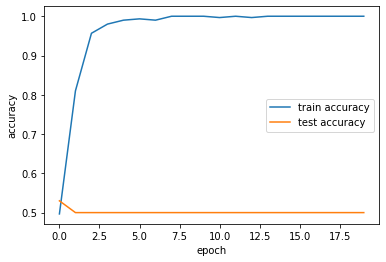

accuracy 0.38798785070578257 



IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [24]:
history = History()
 
img_x = 128
img_y = 101
img_z = 1
input_shape = (img_x, img_y, img_z)
 
num_classes = 2
batch_size = 16
epochs = 20
 
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
 

model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.2))

model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.2))

model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
 
model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[history])
 
train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

plot_history(history)

y_test_pred = model.predict(x_test)

eval_net(model, x_train, y_train)

In [ ]:
y_test_pred

In [ ]:
1. Поиграться с коэффициентом spatialDropout(увеличивать), чтобы точность на тестовых данных была выше. 
2. Сделать ещё один-два "блока"(conv2d-conv2d-batch-dropout).
3. Работать в колабе.
4. Адам - увеличить(чтобы быстрее обучалась), или уменьшить, чтобы обучалась стабильнее.


## P200

In [ ]:
signal_peaks = peaks_features_P200_norm.copy()
signal_cwt   =   cwt_features_P200_norm.copy()
signal_dwt   =   dwt_features_P200_norm.copy()

In [ ]:
###########################
# CWT

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np.array(signal_cwt),
                                                    np.array(y), test_size=0.10,
                                                    random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

In [ ]:
x_train = np.expand_dims(x_train, axis = -1)
x_test = np.expand_dims(x_test, axis = -1)
x_train.shape, x_test.shape

In [ ]:
history = History()
 
img_x = 128
img_y = 101
img_z = 1
input_shape = (img_x, img_y, img_z)
 
num_classes = 2
batch_size = 16
epochs = 20
 
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
 
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
 
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[history])
 
train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

In [ ]:
y_test_pred = model.predict(x_test)

## FRN

In [ ]:
signal_peaks = peaks_features_FRN_norm.copy()
signal_cwt   =   cwt_features_FRN_norm.copy()
signal_dwt   =   dwt_features_FRN_norm.copy()

In [ ]:
###########################
# CWT

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np.array(signal_cwt),
                                                    np.array(y), test_size=0.10,
                                                    random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

In [ ]:
x_train = np.expand_dims(x_train, axis = -1)
x_test = np.expand_dims(x_test, axis = -1)
x_train.shape, x_test.shape

In [ ]:
history = History()
 
img_x = 128
img_y = 81
img_z = 1
input_shape = (img_x, img_y, img_z)
 
num_classes = 2
batch_size = 16
epochs = 20
 
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
 
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
 
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[history])
 
train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

In [ ]:
y_test_pred = model.predict(x_test)

## P300

In [115]:
signal_peaks = peaks_features_P300_norm.copy()
signal_cwt   =   cwt_features_P300_norm.copy()
signal_dwt   =   dwt_features_P300_norm.copy()

In [ ]:
###########################
# CWT

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np.array(signal_cwt),
                                                    np.array(y), test_size=0.10,
                                                    random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

In [ ]:
x_train = np.expand_dims(x_train, axis = -1)
x_test = np.expand_dims(x_test, axis = -1)
x_train.shape, x_test.shape

In [ ]:
history = History()
 
img_x = 128
img_y = 221
img_z = 1
input_shape = (img_x, img_y, img_z)
 
num_classes = 2
batch_size = 16
epochs = 20
 
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
 
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
 
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[history])
 
train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

In [ ]:
y_test_pred = model.predict(x_test)

## N500

In [ ]:
signal_peaks = peaks_features_N500_norm.copy()
signal_cwt   =   cwt_features_N500_norm.copy()
signal_dwt   =   dwt_features_N500_norm.copy()

In [ ]:
###########################
# CWT

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np.array(signal_cwt),
                                                    np.array(y), test_size=0.10,
                                                    random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

In [ ]:
x_train = np.expand_dims(x_train, axis = -1)
x_test = np.expand_dims(x_test, axis = -1)
x_train.shape, x_test.shape

In [ ]:
history = History()
 
img_x = 128
img_y = 21
img_z = 1
input_shape = (img_x, img_y, img_z)
 
num_classes = 2
batch_size = 16
epochs = 20
 
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
 
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
 
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[history])
 
train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

In [ ]:
y_test_pred = model.predict(x_test)